# Number of guests prediction demo

Stripped-down version of [this notebook](https://www.kaggle.com/code/atasaygin/hotel-booking-demand-eda-and-of-guest-prediction).

**Performance** 
- Hotel booking demand dataset
    - Test MAPE City Hotel: 0.249210
    - Test MAPE Resort Hotel: 0.241623
- Lumen dataset `data/raw/lumen_dataset`

# Libraries

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_absolute_percentage_error
import os

for dirname, _, filenames in os.walk('../data/raw'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
warnings.filterwarnings("ignore")

../data/raw\export_df.parquet


In [175]:
data = pd.read_parquet('../data/raw/export_df.parquet')
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


In [90]:
print(len(data))

119210


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119210 entries, 0 to 119209
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   hotel_id                       119210 non-null  int32         
 1   datum_dolaska                  119210 non-null  datetime64[ns]
 2   datum_kreiranja_rezervacije    119210 non-null  datetime64[ns]
 3   datum_odjave                   119210 non-null  datetime64[ns]
 4   datum_otkazivanja_rezervacije  44199 non-null   object        
 5   broj_odraslih_gostiju          119210 non-null  int64         
 6   broj_djece_gostiju             119210 non-null  float64       
 7   zemlja_gosta                   119210 non-null  object        
 8   kanal_prodaje_id               119210 non-null  int32         
 9   tip_sobe_id                    119210 non-null  int32         
 10  cijena_nocenja                 119210 non-null  float64       
 11  

In [86]:
len((data['cijena_nocenja'] /(data['broj_odraslih_gostiju']+data['broj_djece_gostiju'])).unique())

111609

In [30]:
len(data['cijena_nocenja'].unique())

111461

**Some features have wrong datatype. I need to fix that for the following steps.**

In [144]:
NaN = data.isna().sum()
NaN

hotel_id                             0
datum_dolaska                        0
datum_kreiranja_rezervacije          0
datum_odjave                         0
datum_otkazivanja_rezervacije    75011
broj_odraslih_gostiju                0
broj_djece_gostiju                   0
zemlja_gosta                         0
kanal_prodaje_id                     0
tip_sobe_id                          0
cijena_nocenja                       0
status_rezervacije                   0
rezervacija_id                       0
gost_id                              0
dtype: int64

# Data Cleaning

In [176]:
#data = data.drop(['company', 'agent'], axis=1)
data = data.dropna(subset=['zemlja_gosta', 'broj_djece_gostiju','datum_dolaska'], axis=0)
data = data.reset_index(drop=True)
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


In [164]:
print(len(data))
print(f"Resort ima {len(data[data['hotel_id']==0])} zapisa")
print(f"City ima {len(data[data['hotel_id']==1])} zapisa")


119210
Resort ima 40047 zapisa
City ima 79163 zapisa


In [104]:
print(len(data[data['zemlja_gosta']=='0']))

552


In [165]:
data = data[~(data['zemlja_gosta']=='0')]
print(len(data))
print(f"Resort ima {len(data[data['hotel_id']==0])} zapisa")
print(f"City ima {len(data[data['hotel_id']==1])} zapisa")


118658
Resort ima 39583 zapisa
City ima 79075 zapisa


In [177]:
data['broj_djece_gostiju'] = data['broj_djece_gostiju'].astype(int)
data['broj_djece_gostiju'].dtype #It is correct now!

dtype('int32')

In [159]:
# Checking for the missing values after drops
NaN_updated = data.isna().sum()
NaN_updated

hotel_id                             0
datum_dolaska                        0
datum_kreiranja_rezervacije          0
datum_odjave                         0
datum_otkazivanja_rezervacije    75011
broj_odraslih_gostiju                0
broj_djece_gostiju                   0
zemlja_gosta                         0
kanal_prodaje_id                     0
tip_sobe_id                          0
cijena_nocenja                       0
status_rezervacije                   0
rezervacija_id                       0
gost_id                              0
dtype: int64

In [110]:
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0,PRT,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0,PRT,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0,GBR,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0,GBR,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0,GBR,1,130.973278,Check-Out,1313227,1093703


# Creating New Features

In [178]:
# Calculating total guests for each record
data['ukupno_gostiju'] = data['broj_odraslih_gostiju'] + data['broj_djece_gostiju']
data['ukupno_gostiju'].head(10)

0    2
1    2
2    1
3    1
4    2
5    2
6    2
7    2
8    2
9    2
Name: ukupno_gostiju, dtype: int64

In [161]:
print(len(data))

119210


In [179]:
data['duljina_boravka'] = data['datum_odjave'] - data['datum_dolaska']
data['duljina_boravka'] = data['duljina_boravka'].dt.days
data.head(10)


,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id,ukupno_gostiju,duljina_boravka
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313223,1077152,2,0
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313224,1017906,2,0
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0,GBR,0,1,64.991345,Check-Out,1313225,1039896,1,1
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0,GBR,1,1,74.368897,Check-Out,1313226,1008245,1,1
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0,GBR,2,1,130.973278,Check-Out,1313227,1093703,2,2
5,0,2015-07-01,2015-04-21,2015-07-03,None,2,0,GBR,2,1,143.304560,Check-Out,1313228,1044263,2,2
6,0,2015-07-01,2015-06-25,2015-07-03,None,2,0,PRT,0,0,161.502814,Check-Out,1313229,1022260,2,2
7,0,2015-07-01,2014-09-15,2015-07-03,None,2,0,PRT,0,0,151.176542,Check-Out,1313230,1101557,2,2
8,0,2015-07-01,2015-06-30,2015-07-04,2015-05-06,2,0,PRT,2,1,61.437192,Canceled,1313231,1075633,2,3
9,0,2015-07-01,2015-06-28,2015-07-04,2015-04-22,2,0,PRT,2,2,150.365262,Canceled,1313232,1056139,2,3


In [180]:
# Some data points include zero Total Guests, therefore I dropped them
data = data[data['ukupno_gostiju'] != 0]

In [181]:
# Total Number of Days Stayed -- ovo nemamo
# data['Total Stays'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']

dataNoCancel = data[~data['datum_otkazivanja_rezervacije'].notna()]
dataNoCancel = dataNoCancel.reset_index(drop=True)

In [182]:
print(len(dataNoCancel))

75011


In [183]:
dataResort = data[data['hotel_id'] == 0]
dataCity = data[data['hotel_id'] == 1]

assert len(dataResort) + len(dataCity) == len(data)

In [184]:
print(len(dataResort))
print(len(dataCity))

40047
79163


In [119]:
dataResort.columns

Index(['hotel_id', 'datum_dolaska', 'datum_kreiranja_rezervacije',
       'datum_odjave', 'datum_otkazivanja_rezervacije',
       'broj_odraslih_gostiju', 'broj_djece_gostiju', 'zemlja_gosta',
       'tip_sobe_id', 'cijena_nocenja', 'status_rezervacije', 'rezervacija_id',
       'gost_id', 'ukupno_gostiju', 'duljina_boravka'],
      dtype='object')

In [185]:
# Calculating Number of Guests Weekly - Resort Hotel
NumberOfGuestsResort = dataResort[['datum_dolaska', 'ukupno_gostiju']]
NumberOfGuestsWeeklyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsWeeklyResort = NumberOfGuestsWeeklyResort.resample('w').sum().to_frame()
NumberOfGuestsWeeklyResort.head(10)

,ukupno_gostiju
datum_dolaska,
2015-07-05,471
2015-07-12,614
2015-07-19,732
2015-07-26,705
2015-08-02,781
2015-08-09,667
2015-08-16,798
2015-08-23,673
2015-08-30,672


#### kako to da brojevi gostiju toliko odudaraju od originalnog dataframea?
#### samo za city hotel

In [191]:
# Calculating Number of Guests Weekly - Resort Hotel
NumberOfGuestsCity = dataCity[['datum_dolaska', 'ukupno_gostiju']]
NumberOfGuestsWeeklyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity.resample('w').sum().to_frame()
NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity[~(NumberOfGuestsWeeklyCity['ukupno_gostiju']==0)]
NumberOfGuestsWeeklyCity.head(60)

,ukupno_gostiju
datum_dolaska,
2015-01-04,44
2015-01-11,69
2015-01-18,85
2015-01-25,80
2015-02-01,44
2015-05-03,162
2015-05-10,507
2015-05-17,613
2015-05-24,357


# ARIMA Model for Predicting Future Number of Guests


In [192]:
# Dickey-Fuller Test to City Hotel Data
CityWeeklyValues = NumberOfGuestsWeeklyCity.values
result_city = adfuller(CityWeeklyValues)
print('ADF Statistic: %f' % result_city[0])
print('p-value: %f' % result_city[1])
print('Critical Values:')
for key, value in result_city[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.702106
p-value: 0.073675
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579


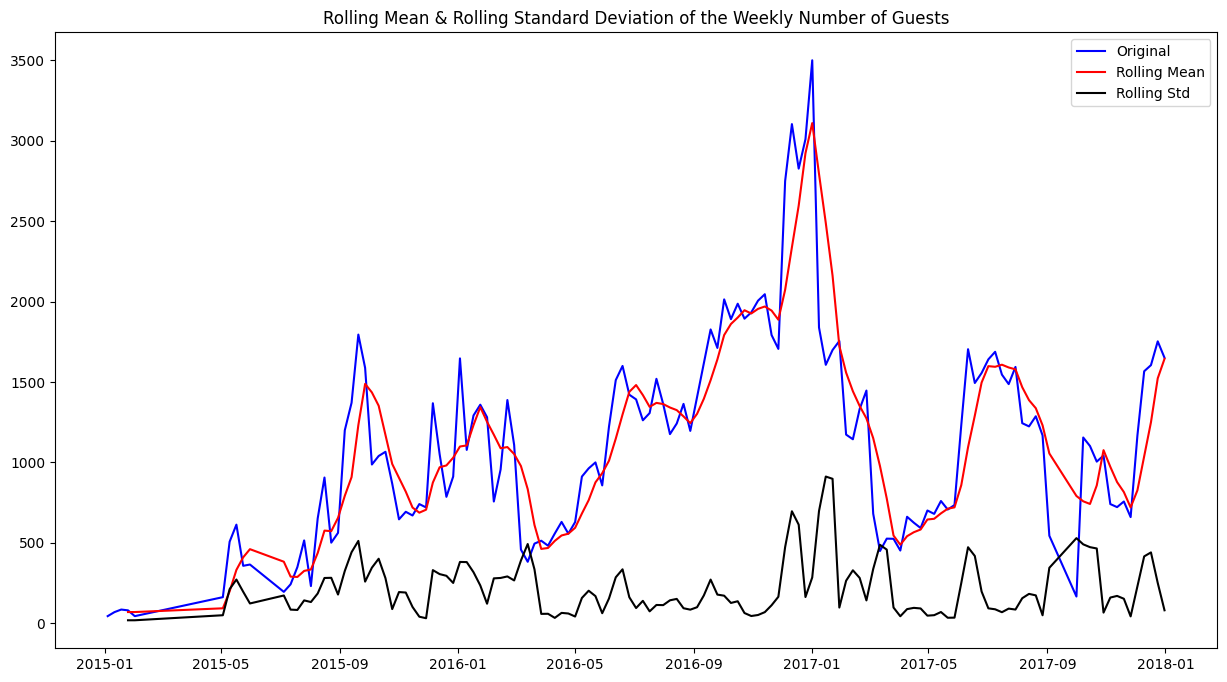

In [193]:
# Rolling Mean & Rolling Standard Deviation of City Hotel
plt.figure(figsize=(15, 8))
rolling_mean = NumberOfGuestsWeeklyCity.rolling(window=4).mean()
rolling_std = NumberOfGuestsWeeklyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsWeeklyCity, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & Rolling Standard Deviation of the Weekly Number of Guests')
plt.show()

In [200]:
train_test_split_city = 90 #int(len(NumberOfGuestsWeeklyCity)*0.8)

trainCity = NumberOfGuestsWeeklyCity[:train_test_split_city]
testCity = NumberOfGuestsWeeklyCity[train_test_split_city:]

In [201]:
# Fit auto_arima function to NumberOfGuests_CityWeekly Dataset
stepwise_fit = auto_arima(trainCity['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic


 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1218.202, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1154.209, Time=0.90 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1237.884, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1161.416, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1152.716, Time=2.36 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.14 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1214.767, Time=1.83 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1154.502, Time=2.49 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1154.172, Time=2.00 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1174.648, Time=2.13 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1155.775, Time=2.92 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=1155.438, Time=1.01 sec

Best model:  A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   90
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -571.358
Date:                            Sun, 11 Feb 2024   AIC                           1152.716
Time:                                    21:10:17   BIC                           1164.500
Sample:                                         0   HQIC                          1157.434
                                             - 90                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    120.6266     75.312      1.602      0.109     -26.983     268.236
ar.L1          0.7555      0.063     11.977      0.000       0.632       0.879
ar.S.L12      -0.5050      0.169     -2.993      0.003      -0.836      -0.174
ar.S.L24      -0.2675      0.199     -1.342      0.180      -0.658       0.123
sigma2      1.293e+05   1.82e+04      7.094      0.000    9.36e+04    1.65e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                14.08
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                            -0.44
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [209]:
modelCity = ARIMA(trainCity['ukupno_gostiju'],
                  order=(3, 0, 0),
                  seasonal_order=(2, 1, 0, 12))

resultCity = modelCity.fit()

# Prediction of the Test data
predictionsCityTest = resultCity.predict(90, 156, typ='levels').rename("Predictions")


# Prediction of Number of Guests (Test Data)


Text(0, 0.5, 'Number of Guests')

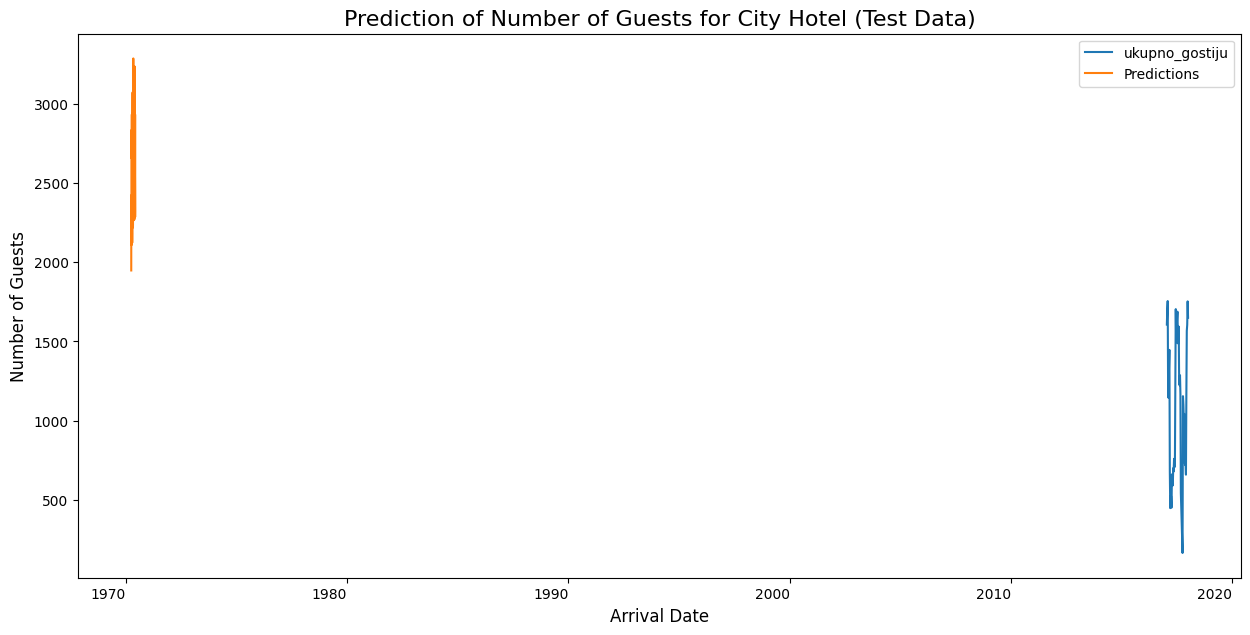

In [210]:
plt.figure(figsize=(15, 8))
testCity['ukupno_gostiju'].plot(legend=True)
predictionsCityTest.plot(legend=True)
plt.title('Prediction of Number of Guests for City Hotel (Test Data)', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

# Prediction of Number of Guests


Text(0, 0.5, 'Number of Guests')

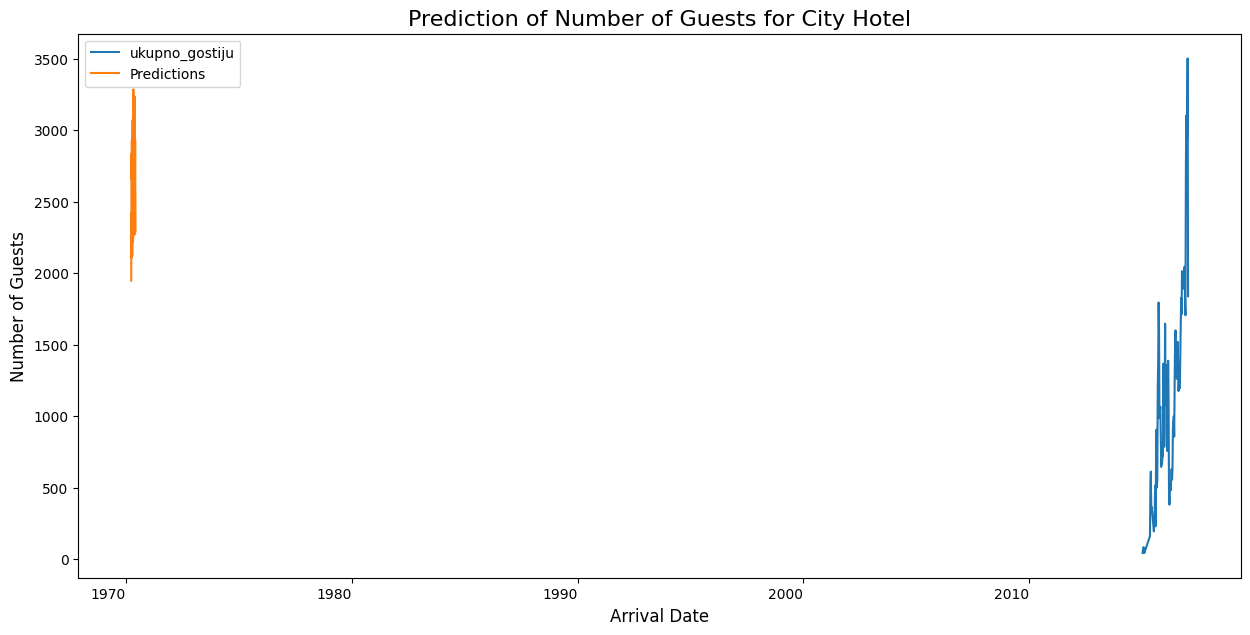

In [211]:
plt.figure(figsize=(15, 8))
trainCity['ukupno_gostiju'].plot(legend=True)
predictionsCityTest.plot(legend=True)
plt.title('Prediction of Number of Guests for City Hotel', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

In [212]:
MeanAbsPercentageErrCity_test = mean_absolute_percentage_error(testCity, predictionsCityTest)
print('Test MAPE City Hotel: %f' % MeanAbsPercentageErrCity_test)

ValueError: Found input variables with inconsistent numbers of samples: [48, 67]

# ARIMA Model for Predicting Future Number of Guests


In [128]:
# Dickey-Fuller Test to City Hotel Data
ResortWeeklyValues = NumberOfGuestsWeeklyResort.values
result_resort = adfuller(ResortWeeklyValues)
print('ADF Statistic: %f' % result_resort[0])
print('p-value: %f' % result_resort[1])
print('Critical Values:')
for key, value in result_resort[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.110674
p-value: 0.000930
Critical Values:
	1%: -3.490
	5%: -2.888
	10%: -2.581


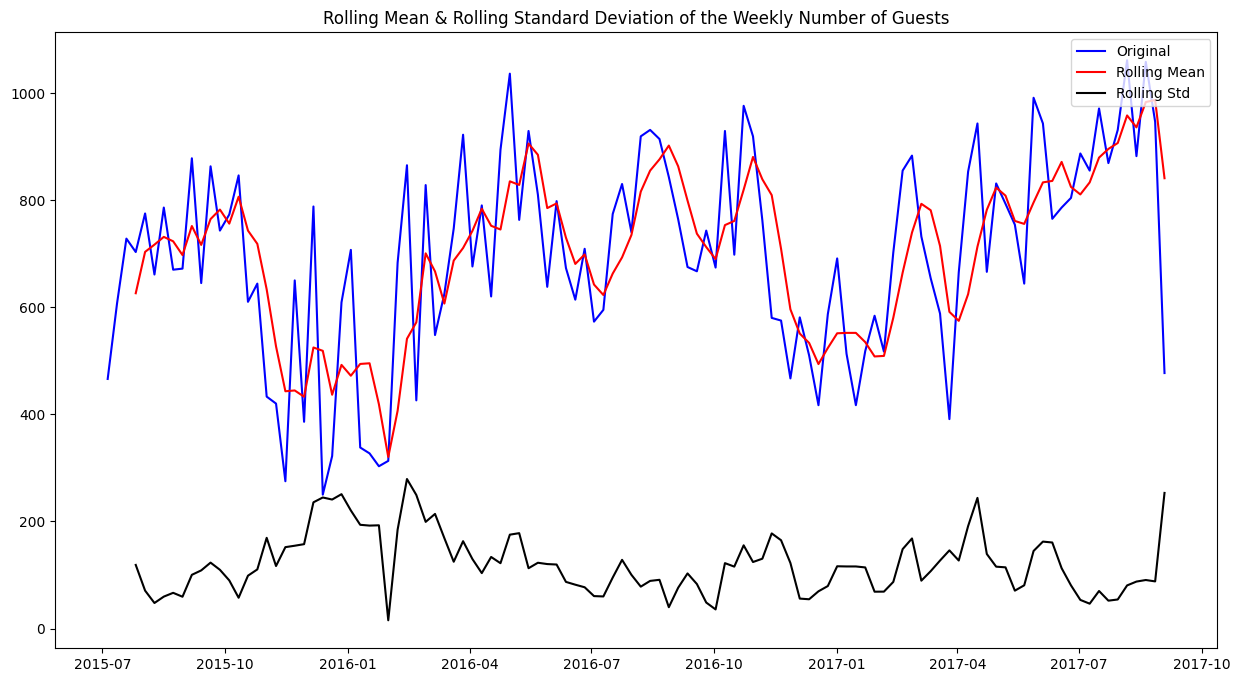

In [129]:
# Rolling Mean & Rolling Standard Deviation of City Hotel
plt.figure(figsize=(15, 8))
rolling_mean_resort = NumberOfGuestsWeeklyResort.rolling(window=4).mean()
rolling_std_resort = NumberOfGuestsWeeklyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsWeeklyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort, color='red', label='Rolling Mean')
plt.plot(rolling_std_resort, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & Rolling Standard Deviation of the Weekly Number of Guests')
plt.show()

In [130]:
len(NumberOfGuestsWeeklyResort)

114

In [131]:
trainResort = NumberOfGuestsWeeklyResort[:90]
testResort = NumberOfGuestsWeeklyResort[90:]

In [132]:
# Fit auto_arima function to NumberOfGuests_ResortWeekly Dataset
stepwise_fit = auto_arima(trainResort['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1089.511, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1056.776, Time=0.89 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1087.638, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1063.127, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1047.995, Time=2.45 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.71 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1074.989, Time=1.75 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1041.344, Time=3.68 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1049.265, Time=1.08 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.24 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=1042.8

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   90
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -514.761
Date:                            Sun, 11 Feb 2024   AIC                           1039.522
Time:                                    20:33:48   BIC                           1051.306
Sample:                                07-05-2015   HQIC                          1044.239
                                     - 03-19-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3871      0.113      3.413      0.001       0.165       0.609
ar.L2          0.3267      0.104      3.136      0.002       0.122       0.531
ar.S.L12      -0.4753      0.133     -3.568      0.000      -0.736      -0.214
ar.S.L24      -0.4151      0.132     -3.153      0.002      -0.673      -0.157
sigma2       2.96e+04   6752.630      4.384      0.000    1.64e+04    4.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 1.27
Prob(Q):                              0.69   Prob(JB):                         0.53
Heteroskedasticity (H):               0.75   Skew:                            -0.05
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
modelResort = ARIMA(trainResort['ukupno_gostiju'],
                    order=(2, 0, 0),
                    seasonal_order=(2, 1, 0, 12))

resultResort = modelResort.fit()

predictionsResortTest = resultResort.predict(90, 113, typ='levels').rename("Predictions")


# Prediction of Number of Guests (Resort Test Data)


Text(0, 0.5, 'Number of Guests')

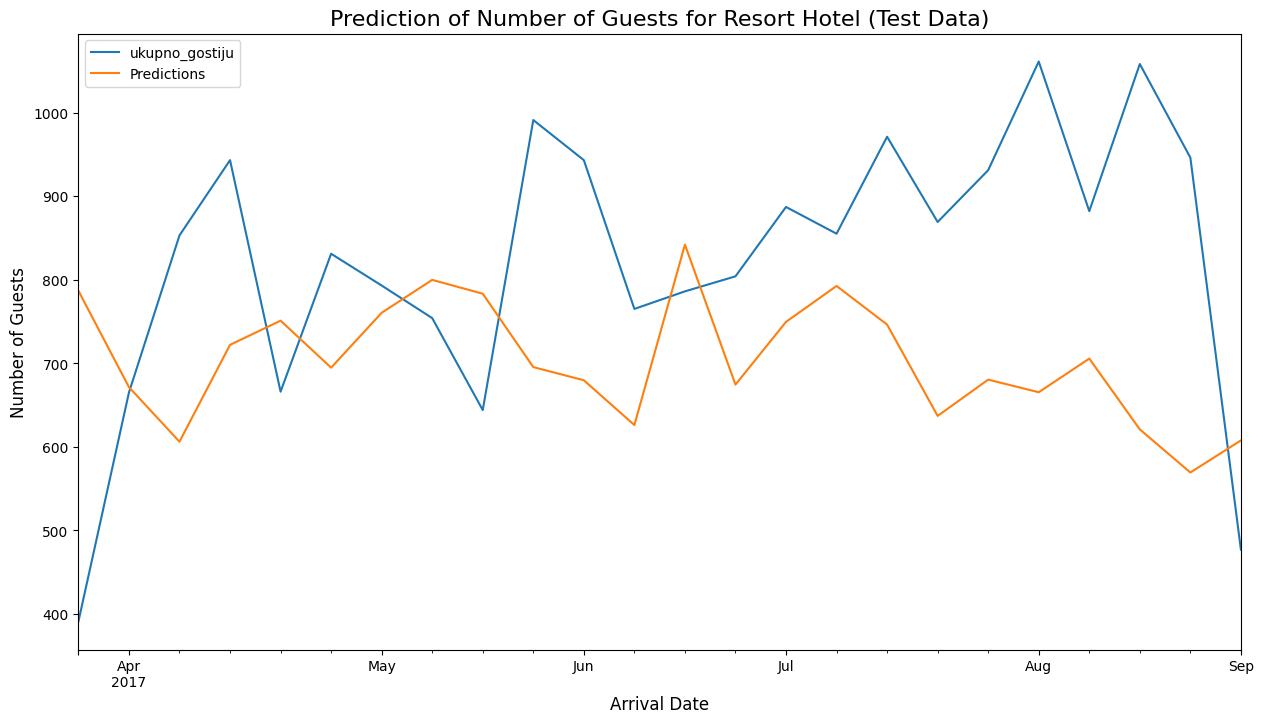

In [135]:
plt.figure(figsize=(15, 8))
testResort['ukupno_gostiju'].plot(legend=True)
predictionsResortTest.plot(legend=True)
plt.title('Prediction of Number of Guests for Resort Hotel (Test Data)', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

# Prediction of Number of Guests for Resort Hotel 


Text(0, 0.5, 'Number of Guests')

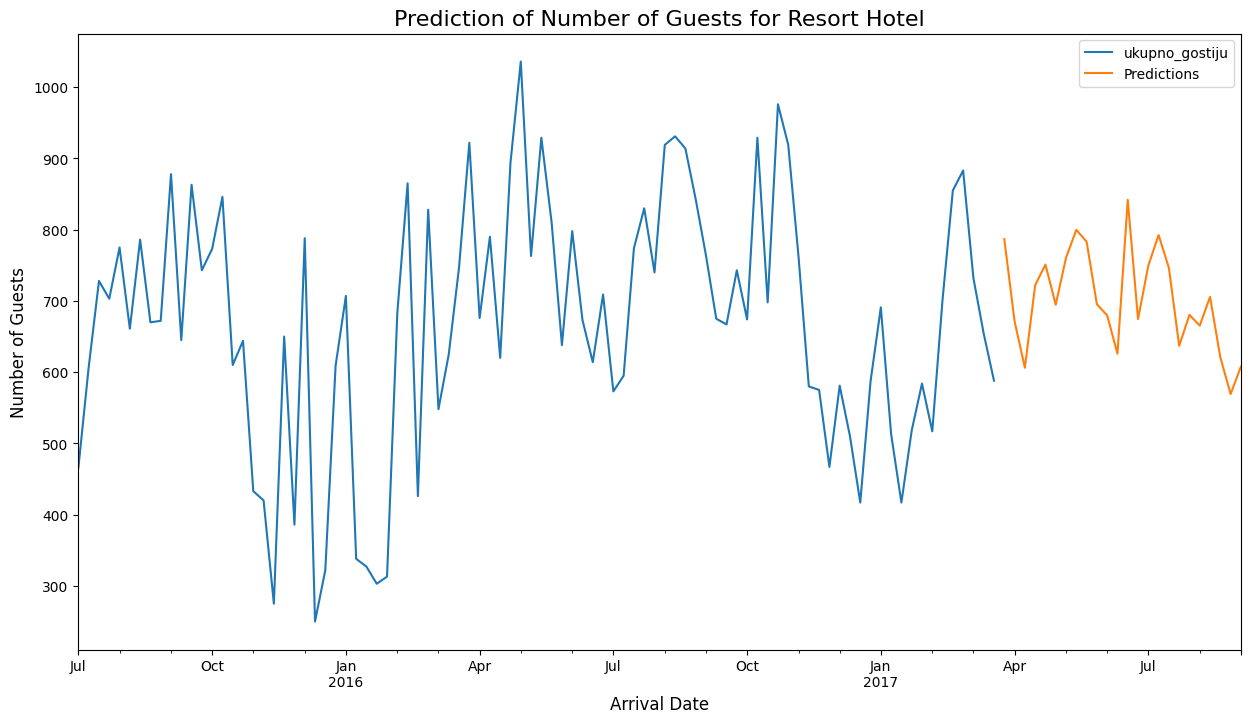

In [140]:
plt.figure(figsize=(15, 8))
trainResort['ukupno_gostiju'].plot(legend=True)
predictionsResortTest.plot(legend=True)
plt.title('Prediction of Number of Guests for Resort Hotel', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

In [141]:
MeanAbsPercentageErrResort_test = mean_absolute_percentage_error(testResort, predictionsResortTest)
print('Test MAPE Resort Hotel: %f' % MeanAbsPercentageErrResort_test)

Test MAPE Resort Hotel: 0.241687
